# Projet  : Classification d'articles de vente, Etude de faisabilité

### Libraries and data loading

In [1]:
#!pip install opencv-python opencv-contrib-python
#!pip install nltk
#!pip install pandas
#!pip install sklearn
#!pip install seaborn
#!pip install keras
#!pip install tensorflow

In [2]:
#Librairies
import pandas as pd
%pylab inline
import seaborn as sns
import cv2
from PIL import Image, ImageOps
sns.set()
from IPython.display import display
import nltk
from sklearn import manifold, decomposition
from sklearn import cluster, metrics

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Data 
images = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

In [4]:
images.shape

(1050, 15)

In [5]:
images.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


### Assigning a category to an image

In [6]:
images.product_category_tree[5]

'["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]'

In [7]:
#separating categories tree functions
def cat_tree(v):
    '''
    To transform product_category_tree in a list more usable
    Return a list, element rank is not changed
    '''
    v = v.replace('["',"").replace('"]',"").split('>>')
    v = [x.strip() for x in v]
    return v

In [8]:
#test
cat_tree(images.product_category_tree[5])

['Watches', 'Wrist Watches', 'Maserati Time Wrist Watches']

In [9]:
images.loc[:,'product_category_tree'] = images['product_category_tree'].map(cat_tree)

images['category_tree_deep'] = images['product_category_tree'].map(len)

In [10]:
images['category_tree_deep'].value_counts()
# we have to note that the deepth is not the same for each product. 

3    368
5    278
4    274
6     70
7     57
2      3
Name: category_tree_deep, dtype: int64

In [11]:
#Level extraction function
def main_cat(v, cut=1):
    '''
    Return a level in the category tree
    cut = 0 corresponds to the root
    '''
    if len(v)-1-cut < 1:
        return np.nan
    else:
        return v[cut]

In [12]:
#test
main_cat(images.product_category_tree[5], 0)

'Watches'

In [13]:
images['category_0'] = images['product_category_tree'].map(lambda x: main_cat(x,cut=0))
images['category_1'] = images['product_category_tree'].map(lambda x: main_cat(x,cut=1))
images['category_2'] = images['product_category_tree'].map(lambda x: main_cat(x,cut=2))

In [14]:
images.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category_tree_deep,category_0,category_1,category_2
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[Home Furnishing, Curtains & Accessories, Curt...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",4,Home Furnishing,Curtains & Accessories,Curtains
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",5,Baby Care,Baby Bath & Skin,Baby Bath Towels
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",5,Baby Care,Baby Bath & Skin,Baby Bath Towels
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",5,Home Furnishing,Bed Linen,Bedsheets
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",5,Home Furnishing,Bed Linen,Bedsheets


In [15]:
#Values counting for each categorizing figure
for i in ['category_0','category_1','category_2']:
    print(i)
    print(f'Number of categories nan included : {len(images[i].unique())}')
    print(images[i].value_counts(dropna=False))
    print()

category_0
Number of categories nan included : 7
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: category_0, dtype: int64

category_1
Number of categories nan included : 62
Wrist Watches                149
Laptop Accessories            87
Infant Wear                   84
Coffee Mugs                   74
Showpieces                    71
                            ... 
Candles & Fragrances           1
Consumables & Disposables      1
JMD Home Furnishing            1
Kripa's Home Furnishing        1
Beauty Accessories             1
Name: category_1, Length: 62, dtype: int64

category_2
Number of categories nan included : 144
NaN                       371
Deodorants                 65
Baby Girls' Clothes        49
Routers                    49
USB Gadgets                38
                       

##### Notes: we have most instances for each category when we keep the root of category tree. Also we have a small numbers of category to process.

### Some pictures visualization

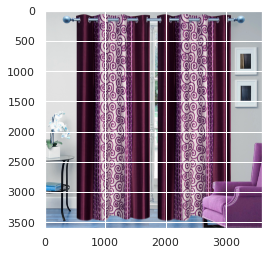

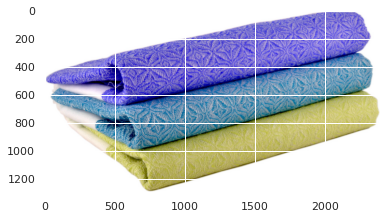

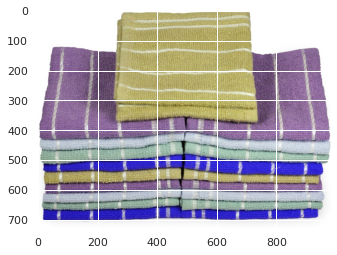

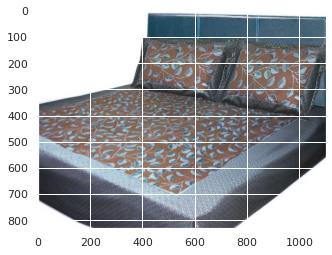

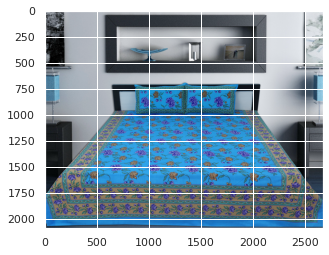

In [16]:
for z in range(5):
    plt.imshow(cv2.imread('./Images/'+images.iloc[z,0]+'.jpg'))
    plt.show()

In [17]:
img_base = cv2.imread('./Images/'+images.iloc[0,0]+'.jpg')

In [18]:
img_rot = cv2.flip(cv2.imread('./Images/'+images.iloc[0,0]+'.jpg'),0)

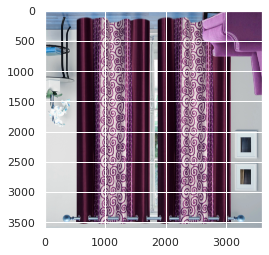

In [19]:
plt.imshow(img_rot)

In [20]:
img_rot.shape

(3600, 3600, 3)

### Unsupervised classification using ORB method for getting descriptors

#### Getting Orb descriptors

In [21]:
# Funtions for getting orb descriptors
def pict_loader(i):
    '''
    image loader
    '''
    photo = cv2.imread('./Images/'+images['uniq_id'][i]+'.jpg')
    return photo

def pict_clean(pict):
    '''
    image preprocessing
    '''
    return pict

def descriptor(i, sift):
    '''
    Getting image descriptors,
    return kp, descriptors (keypoints, descriptors)
    '''
    
    #sift detector
    img = pict_loader(i)
    img = pict_clean(img)
    _sift = sift
    kp, des = _sift.detectAndCompute(img,None)
    if len(kp) ==0:
        img = Image.fromarray(img)
        #img = ImageOps.grayscale(img)
        #img = ImageOps.equalize(img)
        #img = ImageOps.invert(img)
        img = ImageOps.autocontrast(img)
        img = np.array(img)
        kp, des = _sift.detectAndCompute(img,None)
    return  kp, des   

In [22]:
# list of all images descriptors 
orb_keypoints = [descriptor(image, cv2.ORB_create())[1] for image in range(images.shape[0])]

In [23]:
len(orb_keypoints), orb_keypoints[2].shape
# we have 500 descriptors 32 keypoints for each image

(1050, (500, 32))

In [24]:
# convertion orb_keypoints list into array of arrays
orb_keypoints_by_img = np.asarray(orb_keypoints, dtype='object')

# Concatenation all arrays into big one fixing keypoints (32)
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)

In [25]:
orb_keypoints_by_img.shape

(1050,)

In [26]:
orb_keypoints_by_img[1].shape

(500, 32)

In [27]:
orb_keypoints_all.shape

(504039, 32)

In [28]:
orb_keypoints_by_img

array([array([[ 72, 115,  26, ..., 130,  10,  27],
       [121, 184, 152, ..., 132, 203, 139],
       [ 12, 189,  17, ...,   2,   7, 190],
       ...,
       [ 93, 191,  18, ..., 134, 236, 125],
       [ 34, 189,  32, ...,  12, 187, 222],
       [ 93, 187,  88, ..., 132, 236, 125]], dtype=uint8),
       array([[147,  65,  99, ..., 244, 147, 124],
       [ 30,  57, 178, ...,  23,  47, 151],
       [197, 113, 141, ..., 179,   3, 176],
       ...,
       [ 42, 189,  49, ...,  92, 167, 158],
       [ 10, 190, 250, ..., 196, 143, 215],
       [ 58, 221, 115, ..., 154, 116, 249]], dtype=uint8),
       array([[120, 149, 123, ..., 138, 116, 107],
       [218,  27, 122, ..., 141,  61,  91],
       [ 31,  31,  99, ..., 190, 240, 253],
       ...,
       [207, 108, 112, ..., 215, 195, 189],
       [231, 165, 248, ..., 214, 195, 167],
       [189,   4, 111, ..., 241, 242, 224]], dtype=uint8),
       ...,
       array([[145,  94, 142, ..., 121,  40,  91],
       [ 94, 251,  90, ..., 135, 143,  83],

In [29]:
print("Nombre de descripteurs : ", orb_keypoints_all.shape)

Nombre de descripteurs :  (504039, 32)


#### Desriptors clustering

In [30]:
from sklearn import cluster, metrics

# Determination number of clusters"
temps1=time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=3,batch_size=2048 )
kmeans.fit(orb_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  710
Création de 710 clusters de descripteurs ...
temps de traitement kmeans :             7.85 secondes


#### Histogram for each image

In [31]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(orb_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

# Concatenation histogram in array (1050, 710) ~ (number of images, number of clusters) like a dataframe image x features(descriptor clusters)
im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             4.68 secondes


In [32]:
len(hist_vectors)

1050

In [33]:
hist_vectors[1].shape,  type(hist_vectors[1])

((710,), numpy.ndarray)

In [34]:
im_features.shape

(1050, 710)

In [35]:
type(im_features)

numpy.ndarray

#### Reduction of dataset ( image x clusters descriptors) and 2 first tsne dimensions determination

In [36]:
# PCA reduction
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 710)
Dimensions dataset après réduction PCA :  (1050, 556)


In [37]:
# 2 first TSNE Coordonnates
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = images["category_0"]
print(df_tsne.shape)


/home/jp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


#### Displaying TSNE by category

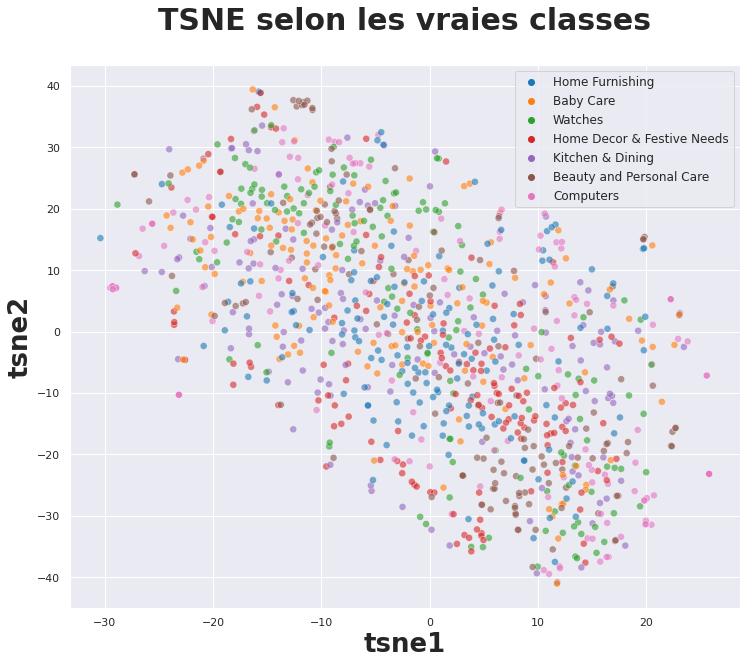

In [38]:
plt.figure(figsize=(12,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette='tab10', s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 12}) 

plt.show()


In [39]:
df_tsne["class"].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: class, dtype: int64

In [40]:
### We don't have encouraging result, it's very difficult to see a group

#### Clustering base on TSNE cordonnates

In [41]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=3)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


In [42]:
pd.Series(cls.labels_).value_counts()

0    179
4    170
1    164
5    152
2    152
6    121
3    112
dtype: int64

<AxesSubplot:xlabel='col_0', ylabel='class'>

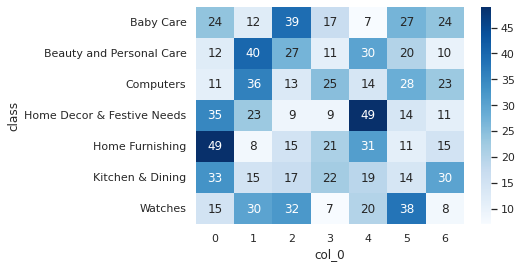

In [43]:
# cross tabulation between true labels and clustrering based on tsne coordonnates
sns.heatmap(pd.crosstab(df_tsne['class'], cls.labels_), annot=True, cmap="Blues")

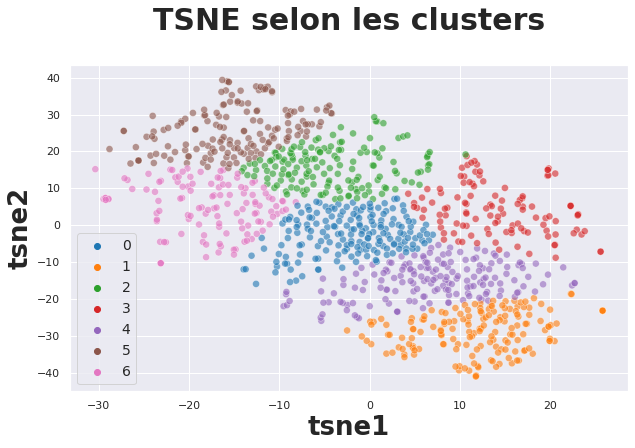

ARI :  0.03332786824205219


In [44]:
## Displaying Clustering based on Tsne coordonnates and ARI score
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette='tab10', s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()
print("ARI : ", metrics.adjusted_rand_score(df_tsne["class"], cls.labels_))

### Global function

In [45]:
def general(algo_keypoints_by_img, algo_keypoints_all, c):
    '''
    c : le nombre de class du jeux de données
    '''
    # Determination number of clusters"
    temps1=time.time()

    k = int(round(np.sqrt(len(algo_keypoints_all)),0))
    print("Nombre de clusters estimés : ", k)
    print("Création de",k, "clusters de descripteurs ...")

    # Clustering
    kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=3,batch_size=2048 )
    kmeans.fit(algo_keypoints_all)

    duration1=time.time()-temps1
    print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

    ### Histogram for each image
    # Creation of histograms (features)
    temps1=time.time()

    def build_histogram(kmeans, des, image_num):
        res = kmeans.predict(des)
        hist = np.zeros(len(kmeans.cluster_centers_))
        nb_des=len(des)
        if nb_des==0 : print("problème histogramme image  : ", image_num)
        for i in res:
            hist[i] += 1.0/nb_des
        return hist


    # Creation of a matrix of histograms
    hist_vectors=[]

    for i, image_desc in enumerate(algo_keypoints_by_img) :
        if i%100 == 0 : print(i)  
        hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector

    im_features = np.asarray(hist_vectors)

    duration1=time.time()-temps1
    print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")
    
    print("Dimensions dataset avant réduction PCA : ", im_features.shape)
    pca = decomposition.PCA(n_components=0.99)
    feat_pca= pca.fit_transform(im_features)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
    
    tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
    X_tsne = tsne.fit_transform(feat_pca)

    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["class"] = images["category_0"]
    print(df_tsne.shape)    

    cls = cluster.KMeans(n_clusters=c, random_state=3)
    cls.fit(X_tsne)

    df_tsne["cluster"] = cls.labels_
    print('df_tsne(cord+label_init+label_kmeans_on_tsne shape',df_tsne.shape, '\n')
    
    print('clustering kmeans sur tsne')
    display(pd.Series(cls.labels_).value_counts() )
    print('\n')
    
    fig, axes = plt.subplots(1,2,figsize=(25,8))
    sns.scatterplot(
        x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
        palette='tab10', s=50, alpha=0.6, ax=axes[0])
    axes[0].set_title('TSNE selon les vraies classes', size = 30, pad = 35, fontweight = 'bold')
    axes[0].set_xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    axes[0].set_ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    axes[0].legend(prop={'size': 12}) 

    sns.scatterplot(
        x="tsne1", y="tsne2", hue="cluster", palette='tab10', s=50, alpha=0.6,
        data=df_tsne, legend="brief",  ax=axes[1])
    axes[1].set_title('TSNE selon les clusters', size = 30, pad = 35, fontweight = 'bold')
    axes[1].set_xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    axes[1].set_ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    axes[1].legend(prop={'size': 12}) 
    
    plt.show()
    
    plt.figure()
    sns.heatmap(pd.crosstab(df_tsne['class'], cls.labels_), annot=True, cmap="Blues")
    plt.show()
    
    print("ARI : ", metrics.adjusted_rand_score(df_tsne["class"], cls.labels_))
    return  cls.labels_
    

### Transfer learning Approch

#### Some usefull functions

In [46]:
#!pip install tensorflow

In [47]:
#!pip install keras

In [48]:
# Function for getting features
def features_extractor(path, model,tg_size ): 
    pth = './Images/'+path+'.jpg'
    image = load_img(pth, target_size=tg_size)  # Charger l'image
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get extracted features
    features = model.predict(image)
    #features = features.reshape(7*7,512)
    #features = np.transpose(features)
    return features


#### Function for displaying quality of transfer learning algorithme
def transfer_learning(model, tg_size=(224, 224, 3)):
    # list of all images descriptors 
    sift_keypoints_tf = [features_extractor(path, model, tg_size) for path in images['uniq_id']]
    sift_keypoints_by_img_tf = np.asarray(sift_keypoints_tf, dtype='object')
    im_features   = np.concatenate(sift_keypoints_by_img_tf, axis=0)
    print("Nombre de descripteurs : ", im_features.shape)
    
    print("Dimensions dataset avant réduction PCA : ", im_features.shape)
    pca = decomposition.PCA(n_components=0.99)
    feat_pca= pca.fit_transform(im_features)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
    
    tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
    X_tsne = tsne.fit_transform(feat_pca)

    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["class"] = images["category_0"]
    print(df_tsne.shape)    

    cls = cluster.KMeans(n_clusters=7, random_state=3)
    cls.fit(X_tsne)

    df_tsne["cluster"] = cls.labels_
    print('df_tsne(cord+label_init+label_kmeans_on_tsne shape',df_tsne.shape, '\n')
    
    print('clustering kmeans sur tsne')
    display(pd.Series(cls.labels_).value_counts() )
    print('\n')
    
    df_tsne["class"]
    
    fig, axes = plt.subplots(1,2,figsize=(25,8))
    sns.scatterplot(
        x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
        palette='tab10', s=50, alpha=0.6, ax=axes[0])
    axes[0].set_title('TSNE selon les vraies classes', size = 30, pad = 35, fontweight = 'bold')
    axes[0].set_xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    axes[0].set_ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    axes[0].legend(prop={'size': 12}) 

    sns.scatterplot(
        x="tsne1", y="tsne2", hue="cluster", palette='tab10', s=50, alpha=0.6,
        data=df_tsne, legend="brief",  ax=axes[1])
    axes[1].set_title('TSNE selon les clusters', size = 30, pad = 35, fontweight = 'bold')
    axes[1].set_xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    axes[1].set_ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    axes[1].legend(prop={'size': 12}) 
    
    plt.show()
    
    plt.figure()
    sns.heatmap(pd.crosstab(df_tsne['class'], cls.labels_), annot=True, cmap="Blues")
    plt.show()
    print("ARI : ", metrics.adjusted_rand_score(df_tsne["class"], cls.labels_))
    return cls.labels_

#### VGG16 Usage

In [49]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras import Model, Input

2021-12-21 15:06:00.933034: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [50]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
#model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3), pooling='avg')
base_model = VGG16(weights="imagenet", input_shape=(224, 224, 3))
# remove the output layer
base_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

2021-12-21 15:06:07.596827: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-21 15:06:08.210383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-21 15:06:08.210440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce MX150 computeCapability: 6.1
coreClock: 1.5315GHz coreCount: 3 deviceMemorySize: 2.00GiB deviceMemoryBandwidth: 44.76GiB/s
2021-12-21 15:06:08.210519: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-21 15:06:08.234685: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-21 15:06:08.234973: I tensorflow/stream_executor/pl

2021-12-21 15:06:21.223413: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-21 15:06:21.235044: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1991995000 Hz
/home/jp/miniconda3/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Nombre de descripteurs :  (1050, 4096)
Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


/home/jp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)
df_tsne(cord+label_init+label_kmeans_on_tsne shape (1050, 4) 

clustering kmeans sur tsne


0    218
2    204
1    188
4    144
3    132
5     84
6     80
dtype: int64

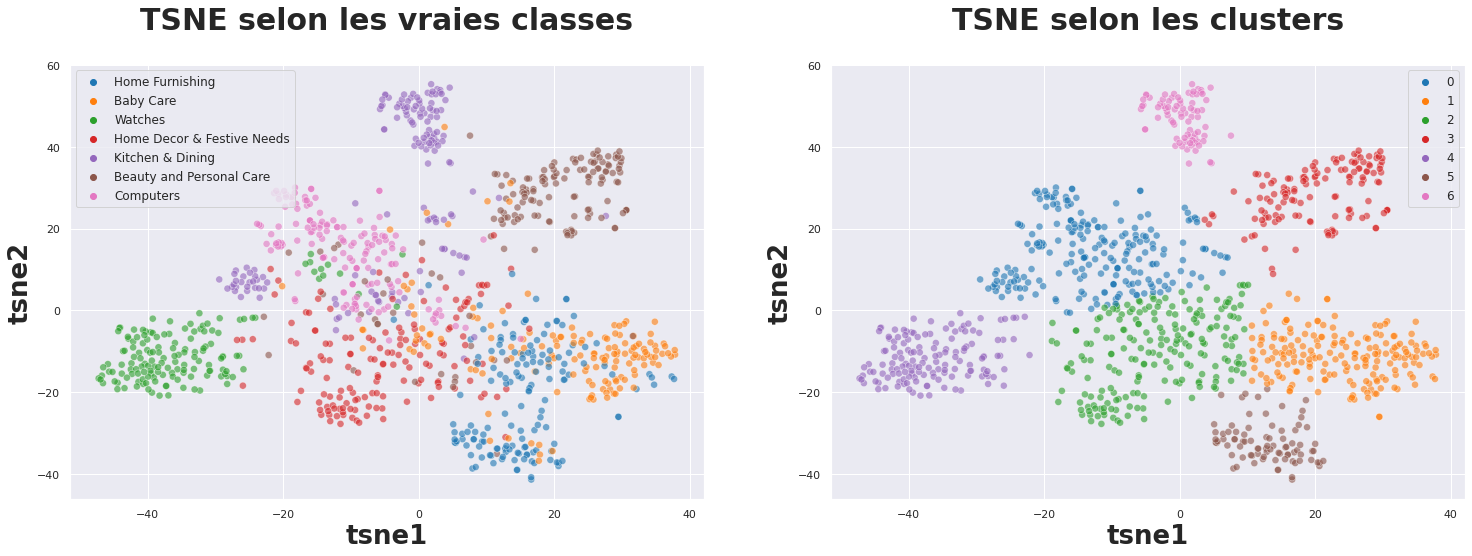

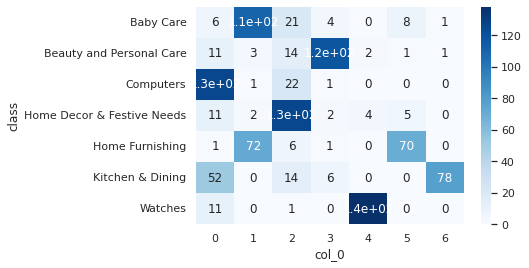

ARI :  0.5090352955186878


array([5, 1, 1, ..., 2, 2, 2], dtype=int32)

In [51]:
transfer_learning(base_model, (224, 224, 3))

#### VGG19 Usage

In [52]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras import Model, Input

2021-12-21 15:12:46.009899: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.
/home/jp/miniconda3/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Nombre de descripteurs :  (1050, 4096)
Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 849)


/home/jp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)
df_tsne(cord+label_init+label_kmeans_on_tsne shape (1050, 4) 

clustering kmeans sur tsne


1    216
6    204
0    162
2    127
5    119
3    114
4    108
dtype: int64

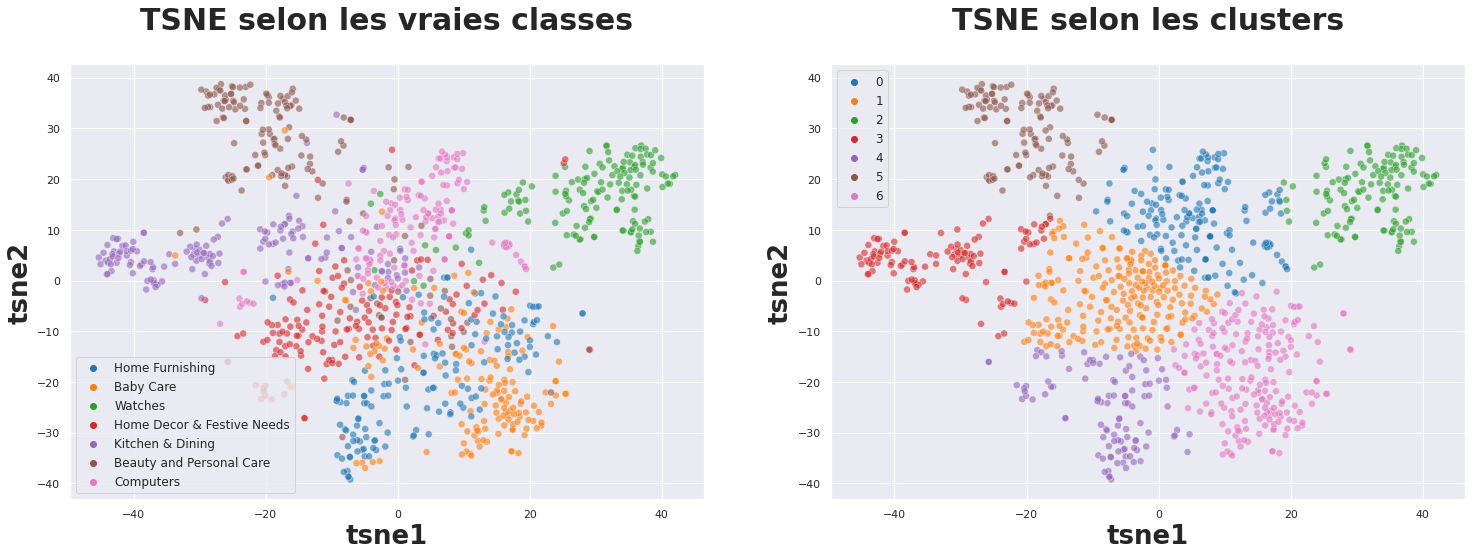

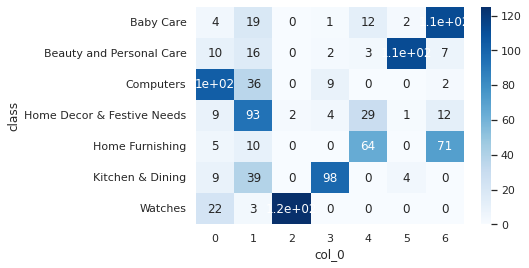

ARI :  0.4287609333831334


array([4, 6, 6, ..., 1, 4, 1], dtype=int32)

In [53]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
base_model_vgg19 = VGG19(weights="imagenet", input_shape=(224, 224, 3))
# remove the output layer
base_model_vgg19 = Model(inputs=base_model_vgg19.inputs, outputs=base_model_vgg19.layers[-3].output)
transfer_learning(base_model_vgg19, (224, 224, 3))

#### Xception usage

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras import Model, Input

2021-12-21 15:43:35.021162: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
base_model_Xception = Xception(weights="imagenet", input_shape=(299, 299, 3), include_top=False)
# remove the output layer
#base_model_NASNetLarge = Model(inputs=base_model_NASNetLarge.inputs, outputs=base_model_NASNetLarge.layers[-3].output)
transfer_learning(base_model_Xception,tg_size=(299, 299, 3))

2021-12-21 15:43:41.192832: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-21 15:43:41.775002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-21 15:43:41.775061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce MX150 computeCapability: 6.1
coreClock: 1.5315GHz coreCount: 3 deviceMemorySize: 2.00GiB deviceMemoryBandwidth: 44.76GiB/s
2021-12-21 15:43:41.775095: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-21 15:43:41.805936: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-21 15:43:41.806050: I tensorflow/stream_executor/pl

NameError: name 'transfer_learning' is not defined

#### Nasnet usage

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras import Model, Input

In [ ]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
base_model_NASNetLarge = NASNetLarge(weights="imagenet", input_shape=(331, 331, 3), include_top=False)
# remove the output layer
#base_model_NASNetLarge = Model(inputs=base_model_NASNetLarge.inputs, outputs=base_model_NASNetLarge.layers[-3].output)
transfer_learning(base_model_NASNetLarge,tg_size=(331, 331, 3))

### Unsupervised classification using textual data

#### Bag of words for each product category

#### Some librairies and functions

In [56]:
#!pip install yellowbrick
from collections import defaultdict
#nltk.download('stopwords')
from nltk.stem.snowball import EnglishStemmer
import string
#nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cluster, metrics, manifold, decomposition

In [57]:
def get_sw(df):
    corpora = defaultdict(list)
    stemmer = EnglishStemmer()
    ##### Bag of words for each category
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    for k,row in df.iterrows():
        corpora[row[1]] += tokenizer.tokenize(
                                        row[0].lower()
                                    )
    stats, freq = dict(), dict()
    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v)} 

    ##### Deleting most common words and stopwords
    freq_totale = nltk.Counter()
    for k, v in corpora.items():
        freq_totale += freq[k]

    most_freq  = list(zip(*freq_totale.most_common(100)))[0]

    sw = set()
    default = nltk.corpus.stopwords.words('english')
    sw.update(most_freq)
    sw.update(tuple(default))

    return sw


def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems


In [58]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [61]:
def text_classif(df_text):
    
    tfidf = TfidfVectorizer(stop_words='english')
    values = tfidf.fit_transform(df_text)
    
    tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
    X_tsne = tsne.fit_transform(values)

    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["class"] = images["category_0"]
    print(df_tsne.shape)    

    cls = cluster.KMeans(n_clusters=7, random_state=3)
    cls.fit(X_tsne)

    df_tsne["cluster"] = cls.labels_
    print('df_tsne(cord+label_init+label_kmeans_on_tsne shape',df_tsne.shape, '\n')

    print('clustering kmeans sur tsne')
    display(pd.Series(cls.labels_).value_counts() )
    print('\n')

    df_tsne["class"]

    fig, axes = plt.subplots(1,2,figsize=(25,8))
    sns.scatterplot(
        x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
        palette='tab10', s=50, alpha=0.6, ax=axes[0])
    axes[0].set_title('TSNE selon les vraies classes', size = 30, pad = 35, fontweight = 'bold')
    axes[0].set_xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    axes[0].set_ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    axes[0].legend(prop={'size': 12}) 

    sns.scatterplot(
        x="tsne1", y="tsne2", hue="cluster", palette='tab10', s=50, alpha=0.6,
        data=df_tsne, legend="brief",  ax=axes[1])
    axes[1].set_title('TSNE selon les clusters', size = 30, pad = 35, fontweight = 'bold')
    axes[1].set_xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    axes[1].set_ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    axes[1].legend(prop={'size': 12}) 

    plt.show()

    plt.figure()
    sns.heatmap(pd.crosstab(df_tsne['class'], cls.labels_), annot=True, cmap="Blues")
    plt.show()
    print("ARI : ", metrics.adjusted_rand_score(df_tsne["class"], cls.labels_))
    return cls.labels_

##### Classification based on product_tilte

/home/jp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)
df_tsne(cord+label_init+label_kmeans_on_tsne shape (1050, 4) 

clustering kmeans sur tsne


6    271
0    263
3    228
1    175
2    104
4      5
5      4
dtype: int64

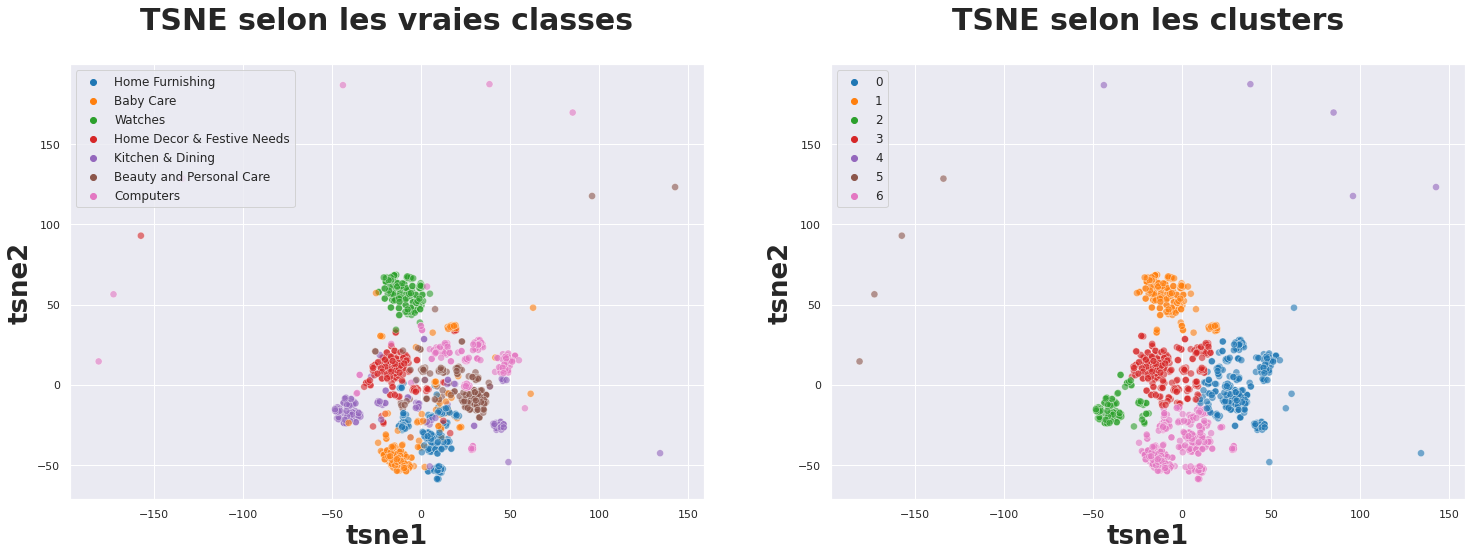

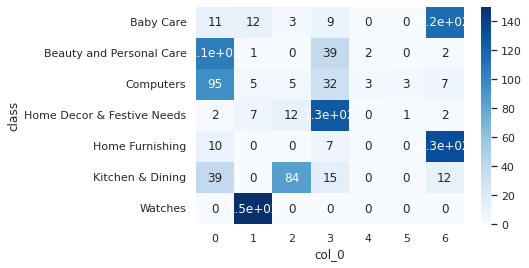

ARI :  0.41539182882480946


array([6, 6, 6, ..., 1, 1, 1], dtype=int32)

In [62]:
short = images.loc[:,['description','product_name','category_0']]
text_classif(short['product_name'])

#### Classification based on product decription

/home/jp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)
df_tsne(cord+label_init+label_kmeans_on_tsne shape (1050, 4) 

clustering kmeans sur tsne


4    181
6    179
5    168
3    149
2    131
0    127
1    115
dtype: int64

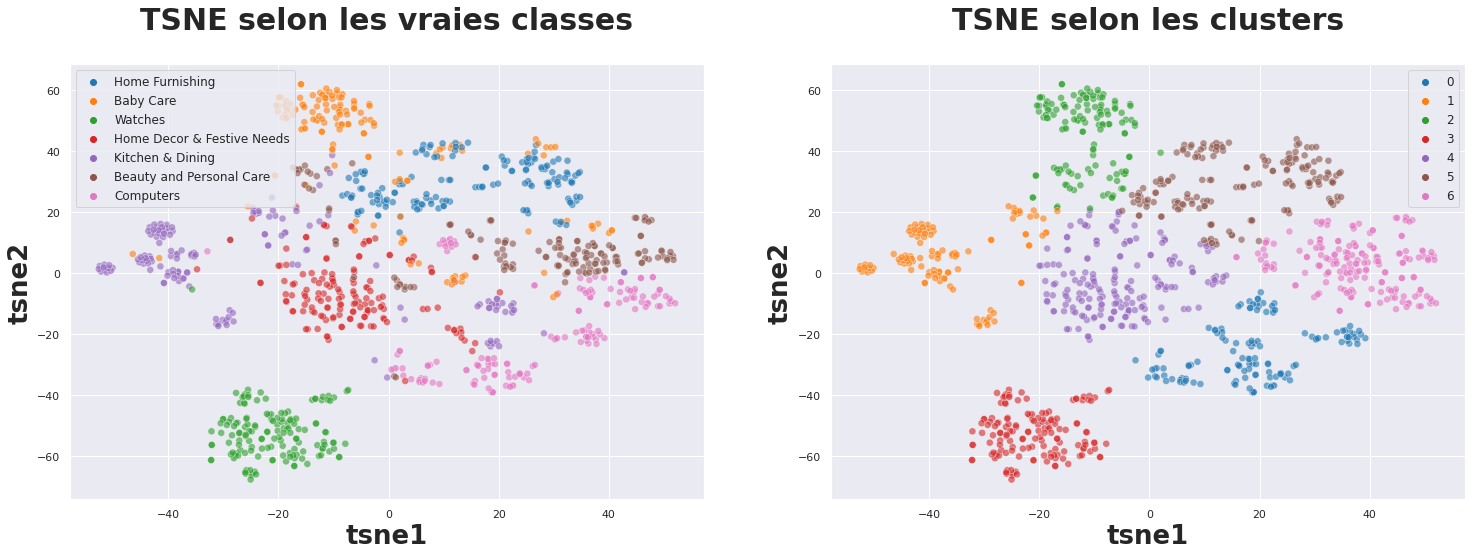

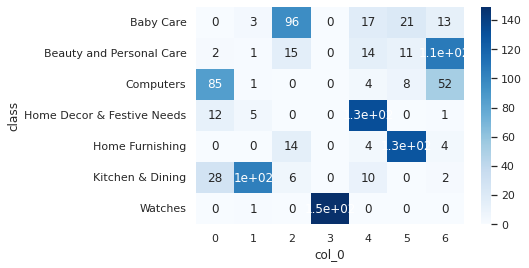

ARI :  0.562838920534142


array([5, 5, 5, ..., 4, 4, 4], dtype=int32)

In [63]:
short = images.loc[:,['description','product_name','category_0']]
text_classif(short['description'])

#### Classification based on product decription + title

/home/jp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)
df_tsne(cord+label_init+label_kmeans_on_tsne shape (1050, 4) 

clustering kmeans sur tsne


0    167
2    156
4    152
1    148
3    148
6    147
5    132
dtype: int64

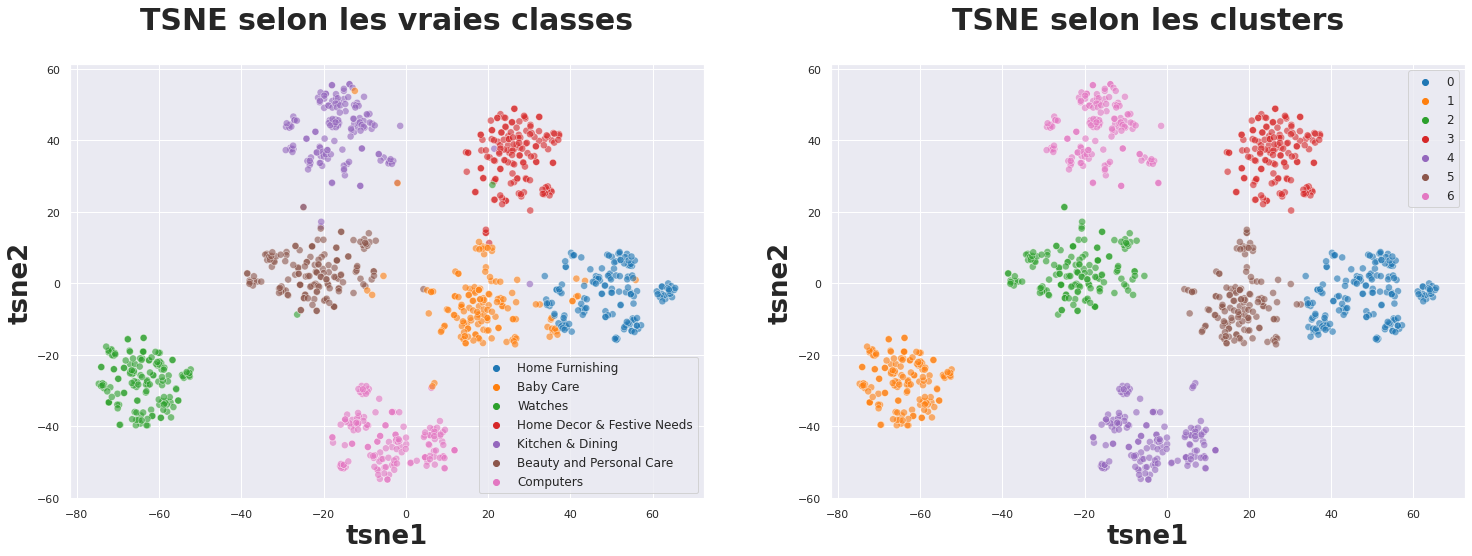

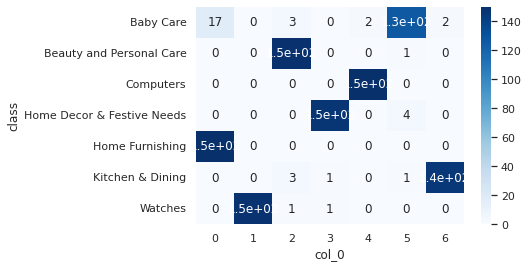

ARI :  0.9243163798414658


array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [64]:
short = images.loc[:,['description','product_name','category_0']]
short['text'] = short['category_0'] + ' '+short['product_name']
text_classif(short['text'])

#### libraries, loading data, some usefull functions

In [65]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [66]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [67]:
# Shorting dataset
short = images.loc[:,['uniq_id','product_name','description','category_0']]
# Creating text data
short['text_concat']=short['product_name'] + str(' ')+ short['description']

In [68]:
# Number of topics expected
n_topics = len(short['category_0'].unique())

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=42)

# topics displaying function
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

#### Using product titles only

In [69]:
ari = []
for i in range(50,1050,50):
    tf_vectorizer = CountVectorizer(max_df=0.95, max_features = i, stop_words='english')
    tf = tf_vectorizer.fit_transform(short['product_name'])
    # Fitter sur les données
    results_lda = lda.fit_transform(tf)
    new_lab = results_lda.argmax(axis=1)
    score = metrics.adjusted_rand_score(short['category_0'], new_lab)
    ari.append(score)
    #print("ARI : ", score)

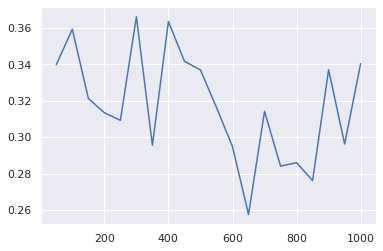

In [70]:
plt.figure()
plt.plot(range(50,1050,50), ari)
plt.show()

Topic 0:
ceramic mug polyester curtain eyelet aroma comfort door design brown
Topic 1:
kadhai cream pack router wireless spf massage oxyglow vitamin fruit
Topic 2:
watch analog cm showpiece men women boys maxima sonata digital
Topic 3:
set combo print pad skin laptop mouse shapes red kit
Topic 4:
sticker vinyl large wallmantra medium ml paper bottle collection king
Topic 5:
baby girl cotton single boy blue towel floral dress comforters
Topic 6:
usb led laptop light cell cover battery hp cushions inch


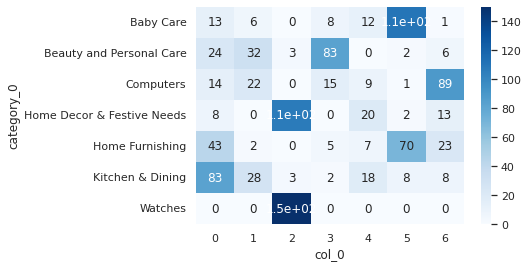

ARI :  0.3660255894070296


In [71]:
tf_vectorizer = CountVectorizer(max_df=0.95, max_features = range(50,1050,50)[pd.Series(ari).argmax()], stop_words='english')
tf = tf_vectorizer.fit_transform(short['product_name'])
# Fitter sur les données
results_lda = lda.fit_transform(tf)
new_lab = results_lda.argmax(axis=1)
display_topics(lda, tf_vectorizer.get_feature_names_out(), no_top_words=10)
plt.figure()
sns.heatmap(pd.crosstab(short['category_0'], new_lab), annot=True, cmap="Blues")
plt.show()
print("ARI : ", metrics.adjusted_rand_score(short['category_0'], new_lab))

#### Using product descriptions only

In [72]:
ari = []
for i in range(50,1050,50):
    tf_vectorizer = CountVectorizer(max_df=0.95, max_features = i, stop_words='english')
    tf = tf_vectorizer.fit_transform(short['description'])
    # Fitter sur les données
    results_lda = lda.fit_transform(tf)
    new_lab = results_lda.argmax(axis=1)
    score = metrics.adjusted_rand_score(short['category_0'], new_lab)
    ari.append(score)
    #print("ARI : ", score)

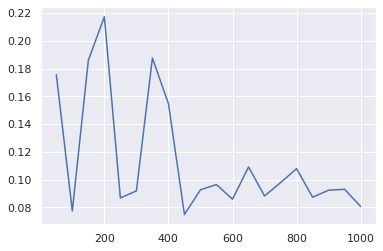

In [73]:
plt.figure()
plt.plot(range(50,1050,50), ari)
plt.show()

Topic 0:
products free rs delivery shipping cash genuine buy 30 day
Topic 1:
skin print set shapes combo multicolor pad cotton mouse sheet
Topic 2:
cm laptop warranty color features model pack box brand type
Topic 3:
mug ceramic coffee perfect mugs gift material safe loved rockmantra
Topic 4:
sticker home wall rs price art paper easy quality room
Topic 5:
watch analog men india great replacement discounts flipkart women com
Topic 6:
baby fabric details girl cotton dress boy specifications pattern ideal


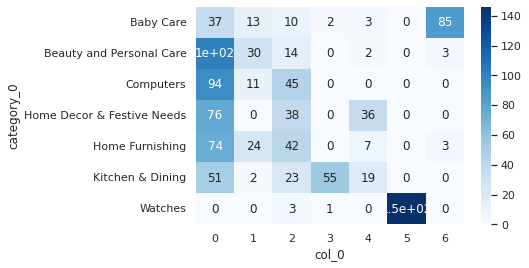

ARI :  0.2173020734535661


In [74]:
tf_vectorizer = CountVectorizer(max_df=0.95, max_features = range(50,1050,50)[pd.Series(ari).argmax()], stop_words='english')
tf = tf_vectorizer.fit_transform(short['description'])
# Fitter sur les données
results_lda = lda.fit_transform(tf)
new_lab = results_lda.argmax(axis=1)
display_topics(lda, tf_vectorizer.get_feature_names_out(), no_top_words=10)
plt.figure()
sns.heatmap(pd.crosstab(short['category_0'], new_lab), annot=True, cmap="Blues")
plt.show()
print("ARI : ", metrics.adjusted_rand_score(short['category_0'], new_lab))

#### Using product titles + descriptions

In [75]:
ari = []
for i in range(50,1050,50):
    tf_vectorizer = CountVectorizer(max_df=0.95, max_features = i, stop_words='english')
    tf = tf_vectorizer.fit_transform(short['text_concat'])
    # Fitter sur les données
    results_lda = lda.fit_transform(tf)
    new_lab = results_lda.argmax(axis=1)
    score = metrics.adjusted_rand_score(short['category_0'], new_lab)
    ari.append(score)
    #print("ARI : ", score)

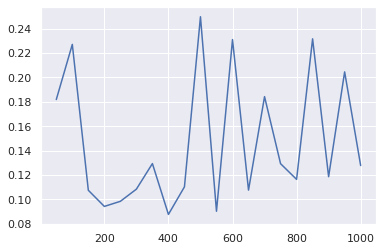

In [76]:
plt.figure()
plt.plot(range(50,1050,50), ari)
plt.show()

Topic 0:
adapter towel replacement quality art bath paper home vgn vaio
Topic 1:
sticker polyester design wall eyelet cm curtain aroma vinyl comfort
Topic 2:
laptop skin warranty set shapes print pad mouse color features
Topic 3:
mug ceramic coffee perfect gift material usb safe rockmantra tea
Topic 4:
watch analog free products delivery shipping cash genuine rs buy
Topic 5:
baby cotton fabric girl details cm printed specifications package general
Topic 6:
cm products showpiece rs free delivery buy shipping genuine cash


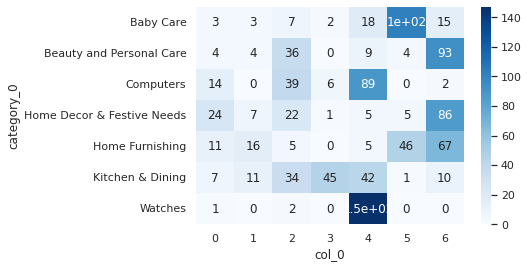

ARI :  0.24963076649566882


In [77]:
tf_vectorizer = CountVectorizer(max_df=0.95, max_features = range(50,1050,50)[pd.Series(ari).argmax()], stop_words='english')
tf = tf_vectorizer.fit_transform(short['text_concat'])
# Fitter sur les données
results_lda = lda.fit_transform(tf)
new_lab = results_lda.argmax(axis=1)
display_topics(lda, tf_vectorizer.get_feature_names_out(), no_top_words=10)
plt.figure()
sns.heatmap(pd.crosstab(short['category_0'], new_lab), annot=True, cmap="Blues")
plt.show()
print("ARI : ", metrics.adjusted_rand_score(short['category_0'], new_lab))